In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly as py
# import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, exists
import random
from random import random as rand

from datetime import date

from tqdm import tqdm

import pingouin as pg

import openpyxl

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
# %config InlineBackend.figure_format = 'retina'
# py.offline.init_notebook_mode(connected = True)

In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
dir_root = '/mnt/ext5/GP'

In [6]:
list_group = ['No stim',r'DLPFC$_{cTBS}$',r'M1$_{cTBS}$',r'DLPFC$_{20Hz}$']

---

## Calculating success rate

In [7]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [8]:
def calc_hit(file_behav, tpr=97, nrun=6):
    ##### parameters #####
    ## file_behav: 불러올 .mat 파일 경로
    ## tpr: trial per run, default=97 (GA project)
    ## nrun: 불러올 run 수, 예) nrun=4 일 경우, r01~r04 까지 데이터를 불러옴
    
    datum = scipy.io.loadmat(file_behav)
    
    ## frame per trial
    fpt = int(datum['nSampleTrial'][0][0])
    ## second per trial
    spt = int(fpt/60.)
    ## a number of trials per run
    # tpr = datum['nTrialperRun'][0][0]
#     tpr = 97  # 12 trial/block * 8 block/run + 1 = 97 trial/run

    ## target ID
    tmp = datum['targetID'][0]
    targetID = tmp[tmp!=0][:tpr*nrun]

    bx = datum['boxSize'][0][0]
    pos = bx*convert_ID(targetID)
    
    ## 60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300
    allXY = datum['allXY']
    
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## target position
    tmp = np.zeros(allXY.shape)
    for i in range(fpt*tpr*nrun):
        t = np.floor(i/fpt).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]

    ## Is it hit?
    err = allXY - tmp
    hit = np.zeros(fpt*tpr*nrun)
    for i in range(fpt*tpr*nrun):
        hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5
        
    return hit

## GA

In [9]:
# dir_work = '/home/sungbeenpark/Github/labs/GA'
# dir_data = join(dir_work, 'behav_data')
# list_behav = sorted(glob(join(dir_data, '*-fmri.mat')))

# df_GA = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
# for i, fname in enumerate(tqdm(list_behav)):
#     subj = fname.split('/')[-1].split('-')[-2]
#     df_GA.loc[i]['subj'] = subj
#     df_GA.loc[i]['group'] = 'GA'
#     hit = calc_hit(fname, tpr=97)
#     for block in range(8*6):
#         run = block // 8 + 1
#         df_GA.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

# df_GA

In [10]:
# dir_work = '/home/sungbeenpark/Github/labs/GA'
# dir_data = join(dir_work, 'behav_data')
# list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

# df_GB = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
# for i, fname in enumerate(tqdm(list_behav)):
#     subj = fname.split('/')[-1].split('-')[-2]
#     df_GB.loc[i]['subj'] = subj.replace('GA','GB')
#     df_GB.loc[i]['group'] = 'GB'
#     hit = calc_hit(fname, tpr=97)
#     for block in range(8*6):
#         run = block // 8 + 1
#         df_GB.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

# df_GB

## GD

In [11]:
# dir_work = '/home/sungbeenpark/Github/labs/GD'
# dir_data = join(dir_work, 'behav_data')
# list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

# df_GD = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
# for i, fname in enumerate(tqdm(list_behav)):
#     subj = fname.split('/')[-1].split('-')[-2]
#     df_GD.loc[i]['subj'] = subj
#     df_GD.loc[i]['group'] = 'GD'
#     hit = calc_hit(fname, tpr=97)
#     for block in range(8*6):
#         run = block // 8 + 1
#         df_GD.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

# df_GD

## GP

In [12]:
# list_dlPFC_cTBS = [
#     '09', '10', '18', '21', '22'
#     , '24', '27', '34', '35', '36'
#     , '38', '42', '57', '59', '62'
#     , '66', '67'
# ]
# list_M1_cTBS = [
#     '08', '11', '17', '19', '20'
#     , '26', '32', '33', '37', '39'
#     , '40', '41', '56', '58', '61'
#     , '63', '65'
# ]
# ## GP50 = GP26
# list_dlPFC_20Hz = [
#     '43', '44', '45', '46', '47'
#     , '48', '49', '51', '53', '54'
#     , '55', '71', '72', '73', '74'
#     , '75'
# #     , '50'
# ]

- GP_DLPFC

In [13]:
# dir_data = join(dir_root, 'behav_data')

# list_behav = []
# for s in list_dlPFC_cTBS:
#     list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
# df_GP_dlpfc = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
# for i, fname in enumerate(tqdm(list_behav)):
#     subj = fname.split('/')[-1].split('-')[-2]
#     df_GP_dlpfc.loc[i]['subj'] = subj
#     df_GP_dlpfc.loc[i]['group'] = 'GP_dlPFC_cTBS'
#     hit = calc_hit(fname, tpr=97, nrun=3)
#     for block in range(8*3):
#         run = block // 8 + 1
#         df_GP_dlpfc.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

# df_GP_dlpfc

- GP_M1

In [14]:
# dir_data = join(dir_root, 'behav_data')

# list_behav = []
# for s in list_M1_cTBS:
#     list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
# df_GP_m1 = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
# for i, fname in enumerate(tqdm(list_behav)):
#     subj = fname.split('/')[-1].split('-')[-2]
#     df_GP_m1.loc[i]['subj'] = subj
#     df_GP_m1.loc[i]['group'] = 'GP_M1_cTBS'
#     hit = calc_hit(fname, tpr=97, nrun=3)
#     for block in range(8*3):
#         run = block // 8 + 1
#         df_GP_m1.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

# df_GP_m1

- GP_High

In [15]:
# dir_data = join(dir_root, 'behav_data')

# list_behav = []
# for s in list_dlPFC_20Hz:
#     list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
# df_GP_high = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
# for i, fname in enumerate(tqdm(list_behav)):
#     subj = fname.split('/')[-1].split('-')[-2]
#     df_GP_high.loc[i]['subj'] = subj
#     df_GP_high.loc[i]['group'] = 'GP_dlPFC_20Hz'
#     hit = calc_hit(fname, tpr=97, nrun=3)
#     for block in range(8*3):
#         run = block // 8 + 1
#         df_GP_high.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

# df_GP_high

### Combining results

In [16]:
# def df_as_long(df, nblock=24):
#     df_res = pd.DataFrame(columns=['subj', 'group', 'block', 'success_rate'])
#     row = 0
#     for i, subj in enumerate(list(df['subj'])):
#         for block in range(nblock):
#             df_res.loc[row, 'subj'] = subj
#             df_res.loc[row, 'group'] = df.loc[i, 'group']
#             df_res.loc[row, 'block'] = block
#             df_res.loc[row, 'success_rate'] = df.loc[i, block]
#             row += 1
#     return df_res

In [17]:
# df = pd.concat(
#     [df_as_long(df_GA)
#      , df_as_long(df_GP_dlpfc)
#      , df_as_long(df_GP_m1)
#      , df_as_long(df_GP_high)]
#     , ignore_index=True
# )

In [18]:
# df.group = df.group.replace('GA', 'No stim')
# df.group = df.group.replace('GP_dlPFC_cTBS', r'DLPFC$_{cTBS}$')
# df.group = df.group.replace('GP_M1_cTBS', r'M1$_{cTBS}$')
# df.group = df.group.replace('GP_dlPFC_20Hz', r'DLPFC$_{20Hz}$')
# df

### Saving the data

In [19]:
# fname = '/home/sungbeenpark/Github/labs/GP/results/behav.success_rate.xlsx'
# df.to_excel(fname, index=False)

---

## Loading the data

In [20]:
fname = '/home/sungbeenpark/Github/labs/GP/results/behav.success_rate.xlsx'
df = pd.read_excel(fname)
df

,subj,group,block,success_rate
0,GA01,No stim,0,0.225833
1,GA01,No stim,1,0.221389
2,GA01,No stim,2,0.370833
3,GA01,No stim,3,0.316389
4,GA01,No stim,4,0.341389
...,...,...,...,...
1915,GP75,DLPFC$_{20Hz}$,19,0.363333
1916,GP75,DLPFC$_{20Hz}$,20,0.253333
1917,GP75,DLPFC$_{20Hz}$,21,0.213611
1918,GP75,DLPFC$_{20Hz}$,22,0.250000


---

## Comparing

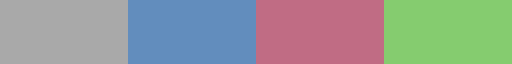

In [21]:
from matplotlib import cm, colors

tmp = cm.turbo(np.linspace(0.1,1.0,4))
# palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp]
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']

colors.ListedColormap(palette)

In [22]:
plt.rcParams['font.size'] = '12'

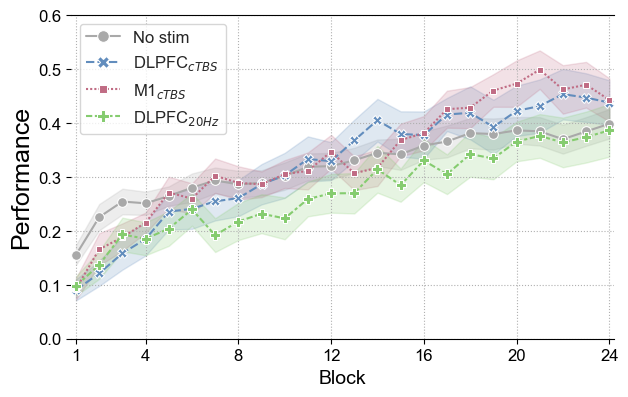

In [23]:
fig, ax = plt.subplots(figsize=(7, 4.2))
# fig.set_size_inches(7, 4.2)

sns.set_style("whitegrid")

g = sns.lineplot(
#     data=df[df.group!='No stim'],
    data=df,
    x='block', y='success_rate', hue='group',
    hue_order=list_group,
    style='group', dashes=True, markers=True, markersize=7,
    errorbar=('se',1), err_style='band',
#     palette=palette[1:],
    palette=palette,
    ax=ax
)

g.legend(markerscale=1.2)

major = [0, 3, 7, 11, 15, 19, 23]
g.set_xlim(-0.2, 23.2)
g.set_xticks(major)
g.set_xticklabels([x + 1 for x in major])
g.set_xlabel('Block', fontsize=14)
g.grid(True, linestyle=':', which='major', axis='both')

g.set_ylim(0, .6)
g.set_ylabel('Performance', fontsize=18)

g.tick_params(axis="x", labelsize=12) 

g.spines['right'].set_visible(False)
g.spines['left'].set_visible(False)

# # ax.set_xticklabels([1,5,9,13,17,21,24])

In [24]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.2a.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

## boxplot

In [25]:
# fig, axs = plt.subplots(ncols=3, figsize=(15, 4.2))

# for ii, run in enumerate(['r01','r02','r03']):
#     ax = axs[ii]
#     dg = df[df.block//8==ii]
#     dh = dg.groupby(['subj', 'group'], as_index=False).mean()
#     sns.swarmplot(
#         data=dh,
#         x='group', y='reward',
#         order=list_group,
#         size=5, palette=palette, linewidth=1,
#         ax=ax
#     )
#     g = sns.boxplot(
#         data=dh,
#         x='group', y='reward',
#         order=list_group,
#         palette=palette,
#         ax=ax
#     )
#     g.set_ylim(0.,0.8)
#     g.set_xlabel('Group', fontsize=14)
#     g.set_ylabel('Performance', fontsize=14)
    
#     print(run)
#     for ii, g1 in enumerate(dh.group.unique()):
#         x1 = ii
#         for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
#             x2 = ii+1+jj
#             a = dh[dh.group==g1].reward
#             b = dh[dh.group==g2].reward
#             _, pval = stats.ttest_ind(a,b)
#             print('(%d,%d (%.3f))'%(x1,x2,pval), convert_pvalue_to_asterisks(pval))

In [23]:
# dh = df[df.block>19].groupby(['subj','group']).mean() - df[df.block<4].groupby(['subj','group']).mean()
dh = df.groupby(['subj','group']).mean()
dh.reset_index(drop=False, inplace=True)
# dh.set_index('subj',inplace=True)
dh

,subj,group,block,success_rate
0,GA01,No stim,11.5,0.366991
1,GA02,No stim,11.5,0.446898
2,GA05,No stim,11.5,0.397407
3,GA07,No stim,11.5,0.279699
4,GA08,No stim,11.5,0.442072
...,...,...,...,...
75,GP71,DLPFC$_{20Hz}$,11.5,0.131238
76,GP72,DLPFC$_{20Hz}$,11.5,0.512998
77,GP73,DLPFC$_{20Hz}$,11.5,0.218472
78,GP74,DLPFC$_{20Hz}$,11.5,0.204606


0 vs 1 (0.59445): ns
0 vs 2 (0.92211): ns
0 vs 3 (0.16450): ns
1 vs 2 (0.72322): ns
1 vs 3 (0.07566): ns
2 vs 3 (0.22113): ns


/tmp/ipykernel_3175946/3318826974.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/tmp/ipykernel_3175946/3318826974.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(


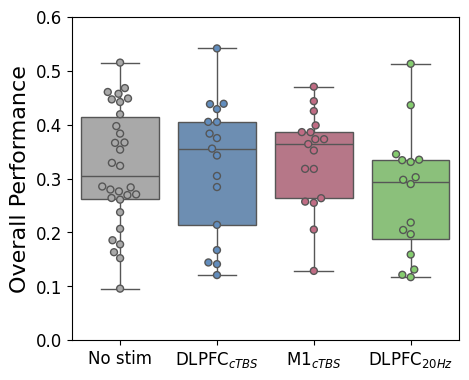

In [25]:
fig, ax = plt.subplots(figsize=(5, 4.2))

sns.swarmplot(
#     data=dh[dh.group!='No stim'],
    data=dh,
    x='group', y='success_rate',
    size=5, linewidth=1,
#     palette=palette[1:],
    order=list_group, palette=palette,
    ax=ax
)
g = sns.boxplot(
#     data=dh[dh.group!='No stim'],
    data=dh,
    x='group', y='success_rate',
#     palette=palette[1:],
    order=list_group, palette=palette,
    ax=ax
)
g.set_ylim(0.0,0.6)
g.set_xlabel('', fontsize=16)
g.set_ylabel('Overall Performance', fontsize=16)

for ii, g1 in enumerate(dh.group.unique()):
    x1 = ii
    for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
        x2 = ii+1+jj
        a = dh[dh.group==g1].success_rate.astype(float)
        b = dh[dh.group==g2].success_rate.astype(float)
        _, pval = stats.ttest_ind(a,b)
        print('%d vs %d (%.5f):'%(x1,x2,pval), convert_pvalue_to_asterisks(pval))

In [26]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.2b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

### One-way ANOVA

In [37]:
pg.anova(
    data=dh,
    dv='success_rate', between='group',
    detailed=False, effsize="np2"
)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,76,1.112463,0.349389,0.042066


---

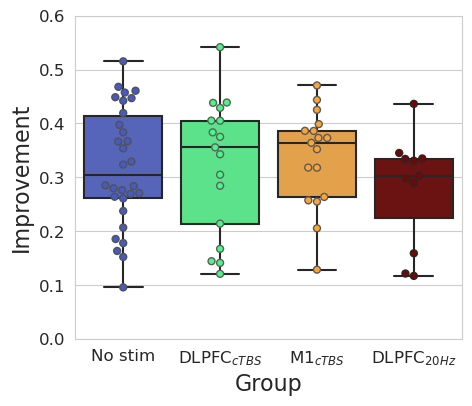

In [25]:
y = {}
y[(0,1)] = 0.58
y[(0,2)] = 0.65
y[(0,3)] = 0.72
dy = 0.04
for ii, g1 in enumerate(dh.group.unique()):
    x1 = ii
    for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
        x2 = ii+1+jj
        a = dh[dh.group==g1].reward
        b = dh[dh.group==g2].reward
        _, pval = stats.ttest_ind(a,b)
        if pval>0.05:
            continue
        
        y1 = a.max()+dy
        y2 = b.max()+dy
        ytext = y[(x1,x2)]
        g.plot([x1,x1],[y1,ytext], 'k-')
        g.plot([x2,x2],[y2,ytext], 'k-')
        g.plot([x1,x2],[ytext,ytext],'k-')
        g.text((x1+x2)*0.5, ytext+0.01, convert_pvalue_to_asterisks(pval), fontsize=12)
fig